# 杭州萧山区项目`WRF-CMAQ`模拟分析
## Spatial Distribution : `chem-obs data`

---
*@author: Evan*\
*@date: 2023-08-30*

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from cnmaps import get_adm_maps, clip_quiver_by_map, clip_contours_by_map, draw_map
import geopandas as gpd
from shapely.ops import unary_union

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.io.shapereader import Reader

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../../src/')
# from findpoint import findpoint
# import ModelEvaLib as me
from namelist import *

## 读取数据

In [2]:
chem = xr.open_dataset(cmaqfile)
met = xr.open_dataset(mcipfile)

lat=chem.latitude
lon=chem.longitude

O3_L1=np.squeeze(chem.O3.sel(level=1000,method='nearest'))

uw_L1=np.squeeze(met.uwind.sel(level=1000,method='nearest'))
vw_L1=np.squeeze(met.vwind.sel(level=1000,method='nearest'))


print('lat & lon = ',lat.shape)
print('chem      = ',O3_L1.shape)

lat & lon =  (138, 135)
chem      =  (744, 138, 135)


In [3]:
# calculate MDA8 O3
mda8_L1 = O3_L1.rolling(time=8).mean().resample({'time':'D'}).max(dim='time')

# calculate average uv wind
uuL1 = uw_L1.resample({'time':'D'}).mean(dim='time')
vvL1 = vw_L1.resample({'time':'D'}).mean(dim='time')

mda8_L1.shape

(31, 138, 135)

In [4]:
# read site lat and lon
sites = pd.read_excel('D:/data/Project_Xiaoshan/obsdata/sites.xlsx',header=0,usecols=['站点','经度','纬度'])

# read obs ozone concentration
# directory containing the Excel files
dir_path = 'D:/data/Project_Xiaoshan/202205/obsdata/sites_2205/'

# create an empty dataframe to store the data
df = pd.DataFrame()

# loop through each file in the directory
for filename in os.listdir(dir_path):
    if filename.endswith('.xlsx'): # make sure it's an Excel file
        # read the Excel file into a dataframe and set the first column as the index
        file_path = os.path.join(dir_path, filename)
        temp_df = pd.read_excel(file_path, index_col=0)
        
        # extract the 'O3' column and add it to the main dataframe
        col_name = filename.split('-')[1].split('.')[0] # use the file name as the column name
        df[col_name] = temp_df['O3']

# calculate observation MDA8 ozone
mda8_obs = df.rolling(8).mean().resample('D').max()
mda8_obs.shape

(31, 24)

使用geopandas和shapely合并polygon对象用于掩膜

In [5]:
zhejiang = get_adm_maps(province='浙江省', record='first', only_polygon=True)
xiaoshan = get_adm_maps(district='萧山区', record='first', only_polygon=True)

hangzhou  = get_adm_maps(city='杭州市', record='first', only_polygon=True)
jiaxing   = get_adm_maps(city='嘉兴市', record='first', only_polygon=True)
shaoxing  = get_adm_maps(city='绍兴市', record='first', only_polygon=True)
huzhou    = get_adm_maps(city='湖州市', record='first', only_polygon=True)
ningbo    = get_adm_maps(city='宁波市', record='first', only_polygon=True)
xuancheng = get_adm_maps(city='宣城市', record='first', only_polygon=True)
jinhua    = get_adm_maps(city='金华市', record='first', only_polygon=True)

multi_polygons = [hangzhou, jiaxing, shaoxing, huzhou, ningbo, jinhua,]# xuancheng]
geo_series = gpd.GeoSeries(multi_polygons)
map_polygon = unary_union(multi_polygons)

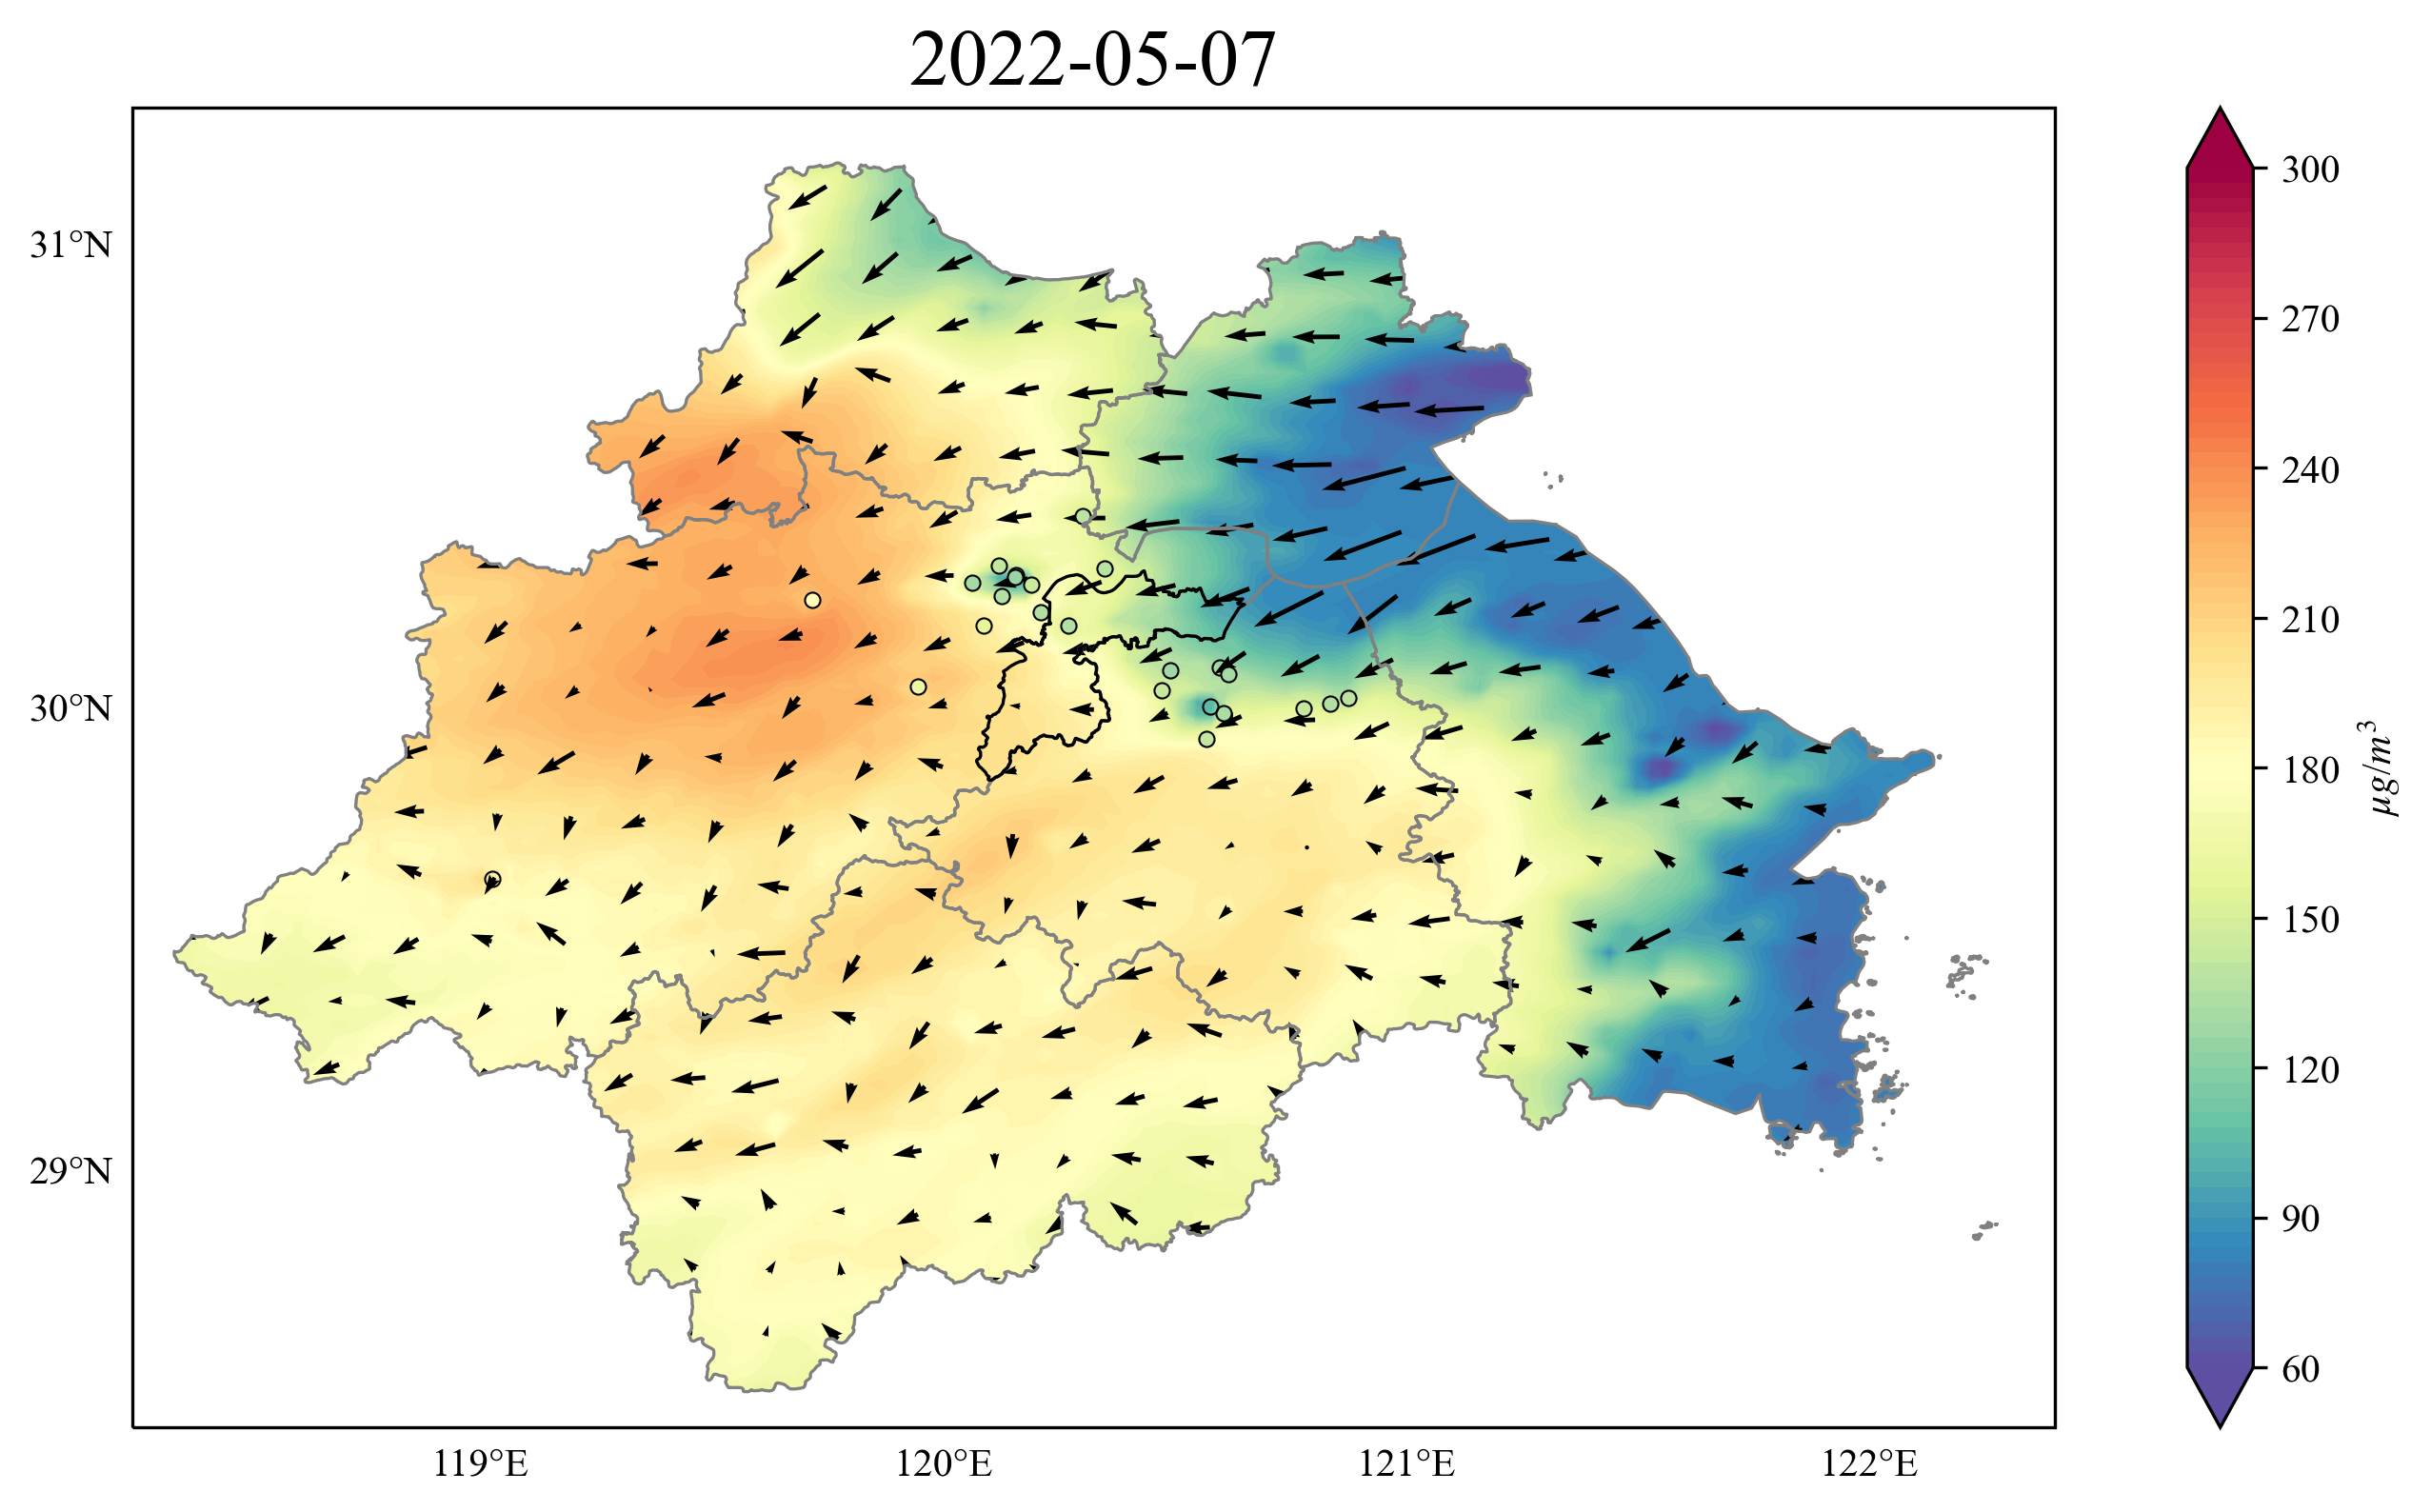

In [6]:
date=7
cmin=60
cmax=301
proj=ccrs.PlateCarree()
# proj=ccrs.LambertConformal(central_longitude=115,central_latitude=32,standard_parallels=(15,40))

fig = plt.figure(figsize=(12,6),dpi=300)
ax = fig.subplots(1,1,subplot_kw={'projection':proj})

# =============================================
# Defining map boundaries
# =============================================

# draw_map(zhejiang, color='gray', linewidth=1)
draw_map(hangzhou, color='gray', linewidth=0.8)
draw_map(jiaxing, color='gray', linewidth=0.8)
draw_map(shaoxing, color='gray', linewidth=0.8)
draw_map(huzhou, color='gray', linewidth=0.8)
draw_map(ningbo, color='gray', linewidth=0.8)
# draw_map(xuancheng, color='gray', linewidth=0.8)
draw_map(jinhua, color='gray', linewidth=0.8)
draw_map(xiaoshan, color='k', linewidth=0.8)

gl=ax.gridlines(
xlocs=np.arange(-180, 180 + 1, 1), ylocs=np.arange(-90, 90 + 1, 1),
draw_labels=True, x_inline=False, y_inline=False,
linewidth=0, linestyle='--', color='gray')
gl.top_labels = False
gl.right_labels =False
gl.rotate_labels=False

ax.set_extent([118.25, 122.4, 28.45, 31.3],ccrs.PlateCarree())


# =============================================
# Pollutants concentration & Mask map
# =============================================

cs = ax.contourf(lon, lat, mda8_L1[date-1,:,:],
                cmap='Spectral_r',
                levels=np.arange(cmin,cmax,3),extend='both',
                transform=ccrs.PlateCarree())

clip_contours_by_map(cs, map_polygon)

# =============================================
# Wind vector map & Mask map
# =============================================

xgrid=np.size(uuL1,2)
ygrid=np.size(vvL1,1)
ngrid=5 # 8 for d03

qv = ax.quiver(lon[0:ygrid:ngrid,0:xgrid:ngrid],lat[0:ygrid:ngrid,0:xgrid:ngrid],
        uuL1[date-1,0:ygrid:ngrid,0:xgrid:ngrid],vvL1[date-1,0:ygrid:ngrid,0:xgrid:ngrid],
        transform=ccrs.PlateCarree(),color='k',alpha=1,scale=150,headwidth=3)

clip_quiver_by_map(qv, map_polygon)

# =============================================
# Stations of observational data
# =============================================

# station obs
# to show all sites
# ax.scatter(sites['经度'],sites['纬度'],transform=ccrs.PlateCarree(),
#                marker='o',s=20,c=mda8_obs.iloc[date-1,:],
#                cmap='Spectral_r',vmin=cmin,vmax=cmax,
#                edgecolors='k',linewidth=0.5)

# to hide some sites
sites_in_xuancheng = ['鳌峰子站','敬亭山子站','开发区子站','夏渡子站']
for m in range(np.size(df.columns)):
    sitename = sites['站点'][m]
    if sitename not in sites_in_xuancheng:
        ax.scatter(sites['经度'][m],sites['纬度'][m],transform=ccrs.PlateCarree(),
                marker='o',s=15,c=mda8_obs[f'{sitename}_2022'][date-1],
                cmap='Spectral_r',vmin=cmin,vmax=cmax,
                edgecolors='k',linewidth=0.5)


# =============================================
# Defining title of the map and colorbar
# =============================================

ax.set_title(pd.to_datetime('2022-05-'+str(date)).strftime('%Y-%m-%d'),size=20)

cbar=plt.colorbar(cs)
cbar.set_label('$\mu$$g$/$m^3$')
cbar.set_ticks(np.arange(cmin,cmax+1,30))

# fig.subplots_adjust(right=0.95,wspace=0.12)
# position= fig.add_axes([0.92,0.15,0.015,0.7])
# cbar=fig.colorbar(cs,cax=position)
# # cbar.set_ticks(np.arange(0,cmax+1,30))
# cbar.set_label('$\mu$$g$/$m^3$')

plt.show()

In [7]:
dates=np.arange(1,32)
cmin=60
cmax=241
proj=ccrs.PlateCarree()
# proj=ccrs.LambertConformal(central_longitude=115,central_latitude=32,standard_parallels=(15,40))
for date in dates:

        fig = plt.figure(figsize=(12,6),dpi=300)
        ax = fig.subplots(1,1,subplot_kw={'projection':proj})

        # =============================================
        # Defining map boundaries
        # =============================================

        # draw_map(zhejiang, color='gray', linewidth=1)
        draw_map(hangzhou, color='gray', linewidth=0.8)
        draw_map(jiaxing, color='gray', linewidth=0.8)
        draw_map(shaoxing, color='gray', linewidth=0.8)
        draw_map(huzhou, color='gray', linewidth=0.8)
        draw_map(ningbo, color='gray', linewidth=0.8)
        # draw_map(xuancheng, color='gray', linewidth=0.8)
        draw_map(jinhua, color='gray', linewidth=0.8)
        draw_map(xiaoshan, color='k', linewidth=0.8)

        gl=ax.gridlines(
        xlocs=np.arange(-180, 180 + 1, 1), ylocs=np.arange(-90, 90 + 1, 1),
        draw_labels=True, x_inline=False, y_inline=False,
        linewidth=0, linestyle='--', color='gray')
        gl.top_labels = False
        gl.right_labels =False
        gl.rotate_labels=False

        ax.set_extent([118.25, 122.4, 28.45, 31.3],ccrs.PlateCarree())

        # =============================================
        # Pollutants concentration & Mask map
        # =============================================

        cs = ax.contourf(lon, lat, mda8_L1[date-1,:,:],
                        cmap='Spectral_r',
                        levels=np.arange(cmin,cmax,3),extend='both',
                        transform=ccrs.PlateCarree())

        clip_contours_by_map(cs, map_polygon)

        # =============================================
        # Wind vector map & Mask map
        # =============================================

        xgrid=np.size(uuL1,2)
        ygrid=np.size(vvL1,1)
        ngrid=5 # 8 for d03

        qv = ax.quiver(lon[0:ygrid:ngrid,0:xgrid:ngrid],lat[0:ygrid:ngrid,0:xgrid:ngrid],
                uuL1[date-1,0:ygrid:ngrid,0:xgrid:ngrid],vvL1[date-1,0:ygrid:ngrid,0:xgrid:ngrid],
                transform=ccrs.PlateCarree(),color='k',alpha=1,scale=150,headwidth=3)

        clip_quiver_by_map(qv, map_polygon)

        # =============================================
        # Stations of observational data
        # =============================================


        # to hide some sites
        sites_in_xuancheng = ['鳌峰子站','敬亭山子站','开发区子站','夏渡子站']
        for m in range(np.size(df.columns)):
                sitename = sites['站点'][m]
                if sitename not in sites_in_xuancheng:
                        ax.scatter(sites['经度'][m],sites['纬度'][m],transform=ccrs.PlateCarree(),
                                marker='o',s=15,c=mda8_obs[f'{sitename}_2022'][date-1],
                                cmap='Spectral_r',vmin=cmin,vmax=cmax,
                                edgecolors='k',linewidth=0.5)


        # =============================================
        # Defining title of the map and colorbar
        # =============================================

        ax.set_title(pd.to_datetime('2022-05-'+str(date)).strftime('%Y-%m-%d'),size=20)

        cbar=plt.colorbar(cs)
        cbar.set_label('$\mu$$g$/$m^3$')
        cbar.set_ticks(np.arange(cmin,cmax+1,30))
        
        plt.savefig('D:/Download/MDA8_'+pd.to_datetime('2022-05-'+str(date)).strftime('%Y-%m-%d'),bbox_inches='tight')
        print('saving '+pd.to_datetime('2022-05-'+str(date)).strftime('%Y-%m-%d'))

        plt.close()

saving 2022-05-01
saving 2022-05-02
saving 2022-05-03
saving 2022-05-04
saving 2022-05-05
saving 2022-05-06
saving 2022-05-07
saving 2022-05-08
saving 2022-05-09
saving 2022-05-10
saving 2022-05-11
saving 2022-05-12
saving 2022-05-13
saving 2022-05-14
saving 2022-05-15
saving 2022-05-16
saving 2022-05-17
saving 2022-05-18
saving 2022-05-19
saving 2022-05-20
saving 2022-05-21
saving 2022-05-22
saving 2022-05-23
saving 2022-05-24
saving 2022-05-25
saving 2022-05-26
saving 2022-05-27
saving 2022-05-28
saving 2022-05-29
saving 2022-05-30
saving 2022-05-31
